In [34]:
Pkg.instantiate()

In [2]:
using Pkg; Pkg.activate(".")


  Activating project at `~/Documents/Julia/Julia_ML_training/unit4`


In [18]:
Threads.nthreads()

4

In [4]:
using Dates

"""
Returns how many tenths of seconds passed since midnight
"""
function time_stamp()
    now = Dates.now()
    midnight = DateTime(Date(now))  # Today at 00:00:00
    return Millisecond(now - midnight).value ÷ 100
end;

In [5]:
before_start = time_stamp()
Threads.@threads for i in 1:17
    println(time_stamp(),
            "."^(time_stamp()-before_start), # spacing proportional to elapsed time
            " Starting iteration $i")

    sleep(1) # sleep for one second as though "processing something"

    println(time_stamp(),
            "."^(time_stamp()-before_start), # spacing proportional to elapsed time
             " Finished sleeping (\"processing\") on thread $(Threads.threadid())")
end

361376. Starting iteration 10
361376. Starting iteration 14
361376. Starting iteration 6
361376. Starting iteration 1
361386........... Finished sleeping ("processing") on thread 4
361386........... Finished sleeping ("processing") on thread 1
361386........... Finished sleeping ("processing") on thread 3
361386........... Starting iteration 11
361386........... Finished sleeping ("processing") on thread 2
361386........... Starting iteration 2
361386........... Starting iteration 7
361386........... Starting iteration 15
361396..................... Finished sleeping ("processing") on thread 3
361396..................... Finished sleeping ("processing") on thread 2
361396..................... Finished sleeping ("processing") on thread 1
361396..................... Starting iteration 16
361396..................... Finished sleeping ("processing") on thread 4
361396..................... Starting iteration 12
361396..................... Starting iteration 3
361396..................... Sta

In [6]:
# Mandelbrot set
function mandelbrot_iter(c::Complex, max_iter::Int=50)::Int
    # initializes z to the zero element of its type, in this case 0+0i
    z = zero(c)
    for i in 1:max_iter
        z = z*z + c
        # abs2 computes the square of the absolute value, saves us a tiny bit by not computing the square root
        if abs2(z) > 4
            return i
        end
    end
    return max_iter
end

mandelbrot_iter (generic function with 2 methods)

In [8]:
mandelbrot_iter(0im)

50

In [9]:
mandelbrot_iter(-1+0im)

50

In [10]:
mandelbrot_iter(3im)

1

In [11]:
function compute_mandelbrot(
    # real (x-axis) values
    real_range,
    # imaginary (y-axis) values
    imag_range;
    # max iterations per run
    max_iter::Int
)::Matrix{Int}
  # produce the grid of c values
  c_grid = complex.(real_range', imag_range)
  # apply mandelbrot_iter to each value of c_grid
  return mandelbrot_iter.(c_grid, max_iter)
end;

In [12]:
width, height = 1500, 1500

real_range_full = LinRange(-2., 0.5, width)
imag_range_full = LinRange(-1.25, 1.25, height);

In [13]:
using BenchmarkTools

@time my_mb = compute_mandelbrot(real_range_full, imag_range_full, max_iter=100);

  0.473292 seconds (611.23 k allocations: 82.227 MiB, 2.15% gc time, 29.47% compilation time)


In [14]:
@time my_mb = compute_mandelbrot(real_range_full, imag_range_full, max_iter=100);

  0.329202 seconds (6 allocations: 51.516 MiB, 1.35% gc time)


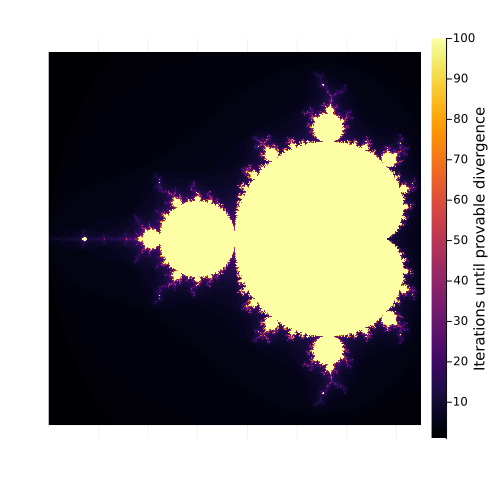

In [15]:
using Plots

heatmap(my_mb, size=(500, 500), axis=false, aspect_ratio=:equal, colorbar_title="Iterations until provable divergence")

  1.067729 seconds (6 allocations: 51.516 MiB, 0.47% gc time)


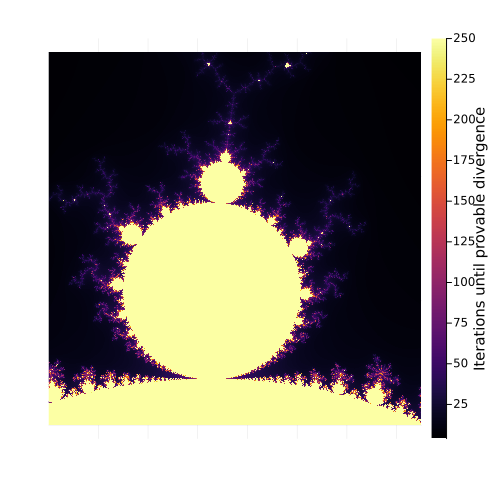

In [15]:
real_range_top = LinRange(-.3, .1, width)
imag_range_top = LinRange(.6, 1, height)

@time my_mb_top = compute_mandelbrot(real_range_top, imag_range_top, max_iter=250);
heatmap(my_mb_top, size=(500, 500), axis=false, aspect_ratio=:equal, colorbar_title="Iterations until provable divergence")

In [1]:
function compute_mandelbrot_multithreaded(
    # real (x-axis) values
    real_range,
    # imaginary (y-axis) values
    imag_range;
    # max iterations per run
    max_iter::Int
)::Matrix{Int}
  # produce the grid of c values
  c_grid = complex.(real_range', imag_range)
  # output array
  out = zeros(Int64, size(c_grid))
  # note the @threads annotation
  Threads.@threads for i in eachindex(out)
    out[i] = mandelbrot_iter(c_grid[i], max_iter)
  end
  return out
end

@time mt_mb = compute_mandelbrot_multithreaded(real_range_full, imag_range_full, max_iter=100);

LoadError: UndefVarError: `real_range_full` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [16]:
using Random
using BenchmarkTools

function do_work()
    if rand() < 0.1
        sleep(.3)
    end
end

do_work (generic function with 1 method)

In [19]:
Random.seed!(1974)

@btime begin
    Threads.@threads :greedy for _ ∈ 1:200
        do_work()
    end
end

  1.209 s (137 allocations: 6.28 KiB)


In [20]:
Random.seed!(1974)

@btime begin
    # same as Threads.@threads :dynamic for _ ∈ 1:200
    Threads.@threads for _ ∈ 1:200
        do_work()
    end
end

  1.215 s (104 allocations: 4.56 KiB)


In [25]:
 ?@threads

No documentation found.

Binding `@threads` does not exist.


In [26]:
?Threads.@threads

```
Threads.@threads [schedule] for ... end
```

A macro to execute a `for` loop in parallel. The iteration space is distributed to coarse-grained tasks. This policy can be specified by the `schedule` argument. The execution of the loop waits for the evaluation of all iterations.

See also: [`@spawn`](@ref Threads.@spawn) and `pmap` in [`Distributed`](@ref man-distributed).

---

REPL.Message("Extended help is available with `??Threads.@threads`", (color = :cyan, bold = true))


In [28]:
function simulate_work(it)
    println(time_stamp(),
            "."^(time_stamp()-before_start), # spacing proportional to elapsed time
            " Starting iteration $it")

    sleep(1) # sleep for one second as though "processing something"

    println(time_stamp(),
            "."^(time_stamp()-before_start), # spacing proportional to elapsed time
             " Finished sleeping (\"processing\") on thread $(Threads.threadid())")

    return it
end

tasks = Vector{Task}()

before_start = time_stamp()
for i in 1:17
    println(i)
    push!(tasks, Threads.@spawn simulate_work(i))
end

println("Spawned $(length(tasks)) tasks")

results = [fetch(task) for task in tasks]
println(time_stamp(), "."^(time_stamp()-before_start) * " Task return values: $results")

1
2
3
388386. Starting iteration 1
4
388386. Starting iteration 3
5
388386. Starting iteration 4
388386. Starting iteration 2
388386. Starting iteration 5
6
388386. Starting iteration 6
7
8
388386. Starting iteration 7
9
388386. Starting iteration 8
388386. Starting iteration 9
10
388386. Starting iteration 10
11
12
388386. Starting iteration 11
388386. Starting iteration 12
13
14
388386. Starting iteration 13
388386. Starting iteration 14
15
388386. Starting iteration 15
16
17
388386. Starting iteration 16
388386. Starting iteration 17
Spawned 17 tasks
388396........... Finished sleeping ("processing") on thread 3
388396........... Finished sleeping ("processing") on thread 1
388396........... Finished sleeping ("processing") on thread 4
388396........... Finished sleeping ("processing") on thread 3
388396........... Finished sleeping ("processing") on thread 3
388396........... Finished sleeping ("processing") on thread 4
388396........... Finished sleeping ("processing") on thread 4

In [30]:
Pkg.add("CUDA")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed LLVMExtra_jll ────── v0.0.35+0
   Installed CUDA_Runtime_jll ─── v0.16.1+0
   Installed Unitful ──────────── v1.22.1
   Installed NVTX_jll ─────────── v3.1.1+0
   Installed CUDA_Driver_jll ──── v0.12.1+1
   Installed GPUCompiler ──────── v1.4.0
   Installed KernelAbstractions ─ v0.9.34
   Installed LLVM ─────────────── v9.3.1
   Installed CUDA ─────────────── v5.7.3
Precompiling CUDA_Driver_jll...
    406.2 ms  ✓ CUDA_Driver_jll
  1 dependency successfully precompiled in 1 seconds. 25 already precompiled.
  No Changes to `~/Documents/Julia/Julia_ML_training/unit4/Project.toml`
  No Changes to `~/Documents/Julia/Julia_ML_training/unit4/Manifest.toml`
Precompiling project...
    501.0 ms  ✓ CUDA_Driver_jll
    503.9 ms  ✓ NVTX_jll
   1225.3 ms  ✓ LLVMExtra_jll
   1280.0 ms  ✓ NVTX
   1834.2 ms  ✓ CUDA_Runtime_jll
   2983.3 ms  ✓ KernelAbstractions
    954.2 ms  ✓ KernelAbstractions →

In [31]:
using CUDA

In [32]:
# this might take a moment
using CUDA

# CUDA.@time is needed to synchronize GPU data to make sure we time everything
CUDA.@time cuda_mb = compute_mandelbrot(CuArray(real_range_full), CuArray(imag_range_full), max_iter=100);

heatmap(cuda_mb, size=(500, 500), axis=false, aspect_ratio=:equal, colorbar_title="Iterations until provable divergence")

LoadError: CUDA driver not found

In [36]:
Pkg.add("Oceananigans")

   Resolving package versions...
   Installed Hwloc_jll ───────────── v2.12.1+0
   Installed MPIPreferences ──────── v0.1.11
   Installed MicrosoftMPI_jll ────── v10.1.4+3
   Installed JLD2 ────────────────── v0.5.14
   Installed Glob ────────────────── v1.3.1
   Installed CubedSphere ─────────── v0.3.2
   Installed METIS_jll ───────────── v5.1.3+0
   Installed OpenMPI_jll ─────────── v5.0.8+0
   Installed MPICH_jll ───────────── v4.3.1+0
   Installed KrylovPreconditioners ─ v0.3.4
   Installed Quaternions ─────────── v0.7.6
   Installed Rotations ───────────── v1.7.1
   Installed TimesDates ──────────── v0.3.1
   Installed ReactantCore ────────── v0.1.15
   Installed SeawaterPolynomials ─── v0.3.10
   Installed IterativeSolvers ────── v0.9.4
   Installed MPItrampoline_jll ───── v5.5.4+0
   Installed TaylorSeries ────────── v0.19.1
   Installed CompoundPeriods ─────── v0.5.4
   Installed Metis ───────────────── v1.5.0
   Installed MPI ─────────────────── v0.20.22
   Installed LightGrap

In [35]:
using Oceananigans
using CairoMakie

grid = RectilinearGrid(GPU(),
                       size = (1024, 1024),
                       x = (-π, π),
                       y = (-π, π),
                       topology = (Periodic, Periodic, Flat))

model = NonhydrostaticModel(; grid, advection=WENO(), tracers=:c)

δ = 0.5
cᵢ(x, y) = exp(-(x^2 + y^2) / 2δ^2)
ϵ(x, y) = 2rand() - 1
set!(model, u=ϵ, v=ϵ, c=cᵢ)

simulation = Simulation(model; Δt=1e-3, stop_time=10)
conjure_time_step_wizard!(simulation, cfl=0.2, IterationInterval(10))
run!(simulation)

u, v, w = model.velocities
ζ = Field(∂x(v) - ∂y(u))

fig = Figure(size=(1200, 600))
axζ = Axis(fig[1, 1], aspect=1, title="vorticity")
axc = Axis(fig[1, 2], aspect=1, title="tracer")
heatmap!(axζ, ζ, colormap=:balance)
heatmap!(axc, model.tracers.c)
current_figure()

LoadError: ArgumentError: Package Oceananigans not found in current path.
- Run `import Pkg; Pkg.add("Oceananigans")` to install the Oceananigans package.